# Computer Vision Project
### Kyle Robinson

Work based on this paper:
    
    Kwatra, Vivek, et al. "Graphcut textures: image and video synthesis using graph cuts." ACM Transactions on Graphics (ToG). Vol. 22. No. 3. ACM, 2003.

In [1]:
import maxflow
import numpy as np
import sklearn
import skimage
import librosa as lr
from librosa import display
import matplotlib.pyplot as plt
import scipy as sp
import math
import pyrubberband

## Playing around with the maxflow package:

In [2]:
g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes((3,3))
structure = np.array([
    [0,0,0],
    [0,0,2],
    [0,1,0]
])
weights = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
])
g.add_grid_edges(nodeids, weights=weights, structure=structure, symmetric=True)

In [3]:
g.add_tedge(8, 10, 0)
g.add_tedge(0, 0, 10)

In [4]:
result = g.maxflow()

In [5]:
print("Flow = "+str(result))
print("Minimum cut:")

g.get_grid_segments(nodeids)


Flow = 3.0
Minimum cut:


array([[ True, False, False],
       [False, False, False],
       [False, False, False]])

# Turning an image into a graph

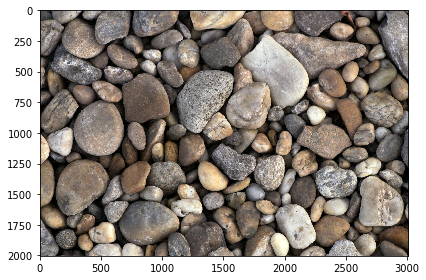

In [6]:
pic1 = skimage.io.imread('rocks.jpg')
skimage.io.imshow(pic1)

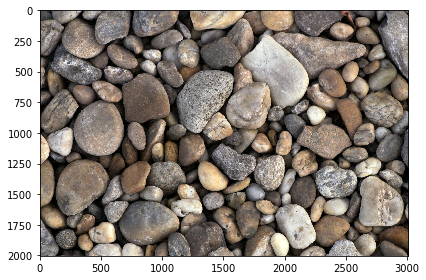

In [7]:
pic2 = skimage.io.imread('rocks.jpg')
skimage.io.imshow(pic2)
overlap = 400

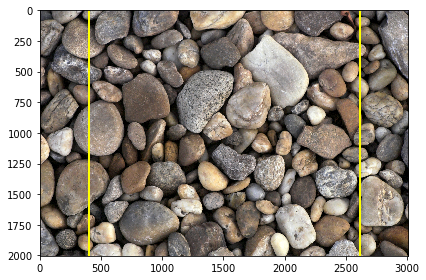

In [8]:
temp_pic = pic2.copy()
temp_pic[:,overlap-5:overlap+5] = [255,255,0]
temp_pic[:,temp_pic.shape[1]-overlap-5:temp_pic.shape[1]-overlap+5] = [255,255,0]
skimage.io.imshow(temp_pic)
skimage.io.imsave('cut_visual.png',temp_pic)

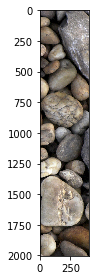

In [9]:
pic1_slice = pic1[:,pic1.shape[1]-overlap:]
skimage.io.imshow(pic1_slice)
skimage.io.imsave('left.png',pic1_slice)

In [ ]:
pic2_slice = pic2[:,:overlap]
skimage.io.imshow(pic2_slice)
skimage.io.imsave('right.png',pic2_slice)

In [ ]:
g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes((pic1_slice.shape[0],pic1_slice.shape[1]))

def get_weight(a1, a2, b1, b2):
    return (np.linalg.norm([a1-b1]) + np.linalg.norm([a2-b2]))

for y in range(pic1_slice.shape[0]):
    g.add_tedge(nodeids[y,0], 999999, 0)
    g.add_tedge(nodeids[y,pic1_slice.shape[1]-1], 0, 999999)
    for x in range(pic1_slice.shape[1]):
        
        if y!=pic1_slice.shape[0]-1:
            g.add_edge(
                nodeids[y,x],
                nodeids[y+1,x],
                get_weight(pic1_slice[y,x], pic1_slice[y+1,x], pic2_slice[y,x], pic2_slice[y+1,x]),
                0)
        if x!=pic1_slice.shape[1]-1:
            g.add_edge(
                nodeids[y,x],
                nodeids[y,x+1],
                get_weight(pic1_slice[y,x], pic1_slice[y,x+1], pic2_slice[y,x], pic2_slice[y,x+1]),
                0)

# Using maxflow to find an optimal cut and stitching together

In [ ]:
result = g.maxflow()
print("Flow = "+str(result))
print("Minimum cut:")
cut = g.get_grid_segments(nodeids)
cut

In [489]:
new_slice = np.zeros((pic1_slice.shape[0], pic1_slice.shape[1], 3), dtype=np.uint8)

for y in range(cut.shape[0]):
    first_right = 10
    for x in range(cut.shape[1]):
        if cut[y,x]:
            new_slice[y,x] = np.array(pic2_slice[y,x])
            if first_right:
                new_slice[y,x] = [255,255,0]
                new_slice[y,x-((10-first_right)*2)] = [255,255,0]
                first_right-=1
        else:
            new_slice[y,x] = np.array(pic1_slice[y,x])
            #new_slice[y,x] = np.array([255,255,255])


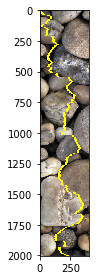

In [490]:
skimage.io.imshow(new_slice)
skimage.io.imsave('cut.png', new_slice)

In [458]:
final_image = np.concatenate((pic1[:,:pic1.shape[1]-overlap], new_slice, pic2[:,overlap:]), axis=1)

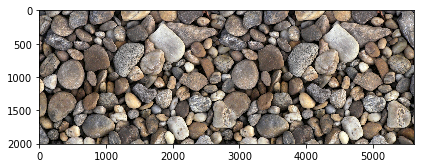

In [482]:
skimage.io.imshow(final_image)
skimage.io.imsave('final_image_clean.png',final_image)

# Building a spectrogram to analyse

In [3]:
file1 = 'dj1.ogg'
file2 = 'dj2.ogg'
y1, sr = lr.core.load(file1, sr=None)
y2, sr2 = lr.core.load(file2, sr=sr)

#y1 = y1[:y1.shape[0]-(y1.shape[0]//4)]

In [4]:
#S = lr.feature.melspectrogram(y=y, sr=sr, n_mels=32, fmax=8000, hop_length=2)
tempo1, beats1 = lr.beat.beat_track(y=y1, sr=sr, bpm=124)
tempo2, beats2 = lr.beat.beat_track(y=y2, sr=sr2, bpm=120)

y2 = pyrubberband.pyrb.time_stretch(y2, sr2, rate=tempo1/tempo2)
#y2 = lr.effects.time_stretch(y2, tempo1/tempo2)
#tempo2test, beats2test = lr.beat.beat_track(y=y2, sr=sr)

fourier_transformed1 = lr.stft(y1, n_fft=2048)
fourier_transformed2 = lr.stft(y2, n_fft=2048)

#Restrict first song to end one beat after last
fourier_transformed1 = fourier_transformed1[:,:beats1[-1]+(beats1[-1]-beats1[-2])]

print(fourier_transformed1.shape, fourier_transformed2.shape)

(1025, 24106) (1025, 23528)


In [6]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,4))
#display.specshow(lr.amplitude_to_db(fourier_transformed1, ref=np.max),
#                         y_axis='log',
#                         x_axis='time')
#plt.colorbar(format='%+2.0f dB')
#plt.title('Power spectrogram')
#plt.tight_layout()
#plt.show()

In [7]:
overlap = (fourier_transformed1.shape[1]-beats1[-63])+(beats2[0])
overlap

2656

In [8]:
s1 = fourier_transformed1[:,fourier_transformed1.shape[1]-overlap:]
s1dB = lr.amplitude_to_db(s1, ref=np.max)
#plt.figure(figsize=(10,4))
#display.specshow(lr.amplitude_to_db(s1, ref=np.max),
#                         y_axis='log',
#                         x_axis='time')
#plt.colorbar(format='%+2.0f dB')
#plt.title('Power spectrogram')
#plt.tight_layout()
#plt.show()

c:\program files\python36\lib\site-packages\librosa\core\spectrum.py:1029: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [9]:
s2 = fourier_transformed2[:,:overlap]
s2dB = lr.amplitude_to_db(s2, ref=np.max)
#plt.figure(figsize=(10,4))
#display.specshow(lr.amplitude_to_db(s2, ref=np.max),
#                         y_axis='log',
#                         x_axis='time')
#plt.colorbar(format='%+2.0f dB')
#plt.title('Mel spectrogram')
#plt.tight_layout()
#plt.show()

c:\program files\python36\lib\site-packages\librosa\core\spectrum.py:1029: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


# Inputting the audio data into a graph

In [10]:
s1.shape

(1025, 2656)

In [11]:
g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes((s1.shape[0],s1.shape[1]))

def get_weight(a1, a2, b1, b2):
    return (np.linalg.norm([a1-b1]) + np.linalg.norm([a2-b2]))

for row in range(s1.shape[0]):
    g.add_tedge(nodeids[row,0], 999999, 0)
    g.add_tedge(nodeids[row,s1.shape[1]-1], 0, 999999)
    for x in range(s1.shape[1]):
        #if row == 0:
        #    g.add_tedge(nodeids[row,x], 999999, 0)
        #elif row == s1.shape[0]-1:
        #    g.add_tedge(nodeids[row,x], 0, 999999)
            
        if row!=s1.shape[0]-1:
            g.add_edge(
                nodeids[row,x],
                nodeids[row+1,x],
                get_weight(s1dB[row,x], s1dB[row+1,x], s2dB[row,x], s2dB[row+1,x]),
                0)
        if x!=s1.shape[1]-1:
            g.add_edge(
                nodeids[row,x],
                nodeids[row,x+1],
                get_weight(s1dB[row,x], s1dB[row,x+1], s2dB[row,x], s2dB[row,x+1]),
                0)

In [12]:
result = g.maxflow()
print("Flow = "+str(result))
print("Minimum cut:")
cut = g.get_grid_segments(nodeids)
cut

Flow = 1044.9489994049072
Minimum cut:


array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]])

In [13]:
new_slice = np.zeros((s1.shape[0], s1.shape[1]), dtype=np.complex64)

for row in range(cut.shape[0]):
    for x in range(cut.shape[1]):
        if cut[row,x]:
            new_slice[row,x] = np.array(s2[row,x])
            #new_slice[row,x] = 999
        else:
            new_slice[row,x] = np.array(s1[row,x])
            #new_slice[row,x] = np.array(70)
            
result = np.concatenate((fourier_transformed1[:,:fourier_transformed1.shape[1]-overlap],new_slice,fourier_transformed2[:,overlap:]), axis=1)
#result = np.concatenate((fourier_transformed1[:,:fourier_transformed1.shape[1]-overlap],new_slice,fourier_transformed2[:,overlap:fourier_transformed2.shape[1]-overlap],new_slice,fourier_transformed1[:,overlap:fourier_transformed1.shape[1]-overlap],new_slice,fourier_transformed2[:,overlap:]), axis=1)

In [14]:
output_name = 'test_augmented_recon_'+str(file1[:-4])+str(file2[:-4])+'.wav'
lr.output.write_wav(output_name, lr.core.istft(result), sr=sr)

c:\program files\python36\lib\site-packages\librosa\core\spectrum.py:1029: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


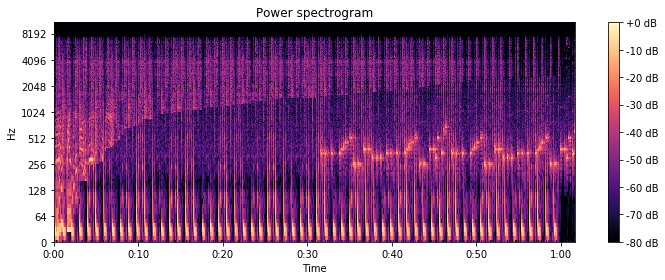

In [15]:
show_slice = np.zeros((s1.shape[0], s1.shape[1]), dtype=np.complex64)

for row in range(cut.shape[0]):
    first_right = 10
    for x in range(cut.shape[1]):
        if cut[row,x]:
            #if first_right:
                #show_slice[row,x] = 999
                #show_slice[row,x-((10-first_right)*2)] = 999
                #first_right -=1
            #else:
            show_slice[row,x] = np.array(s2[row,x])
        else:
            show_slice[row,x] = np.array(s1[row,x])
            
show_result = np.concatenate((fourier_transformed1[:,:fourier_transformed1.shape[1]-overlap],show_slice,fourier_transformed2[:,overlap:]), axis=1)
#result = np.concatenate((fourier_transformed1[:,:fourier_transformed1.shape[1]-overlap],new_slice,fourier_transformed2[:,overlap:fourier_transformed2.shape[1]-overlap],new_slice,fourier_transformed1[:,overlap:fourier_transformed1.shape[1]-overlap],new_slice,fourier_transformed2[:,overlap:]), axis=1)

#show_result = show_result[]

plt.figure(figsize=(10,4))
display.specshow(lr.amplitude_to_db(show_slice, ref=np.max),
                         y_axis='log', 
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Power spectrogram')
plt.tight_layout()
plt.show()

c:\program files\python36\lib\site-packages\librosa\core\spectrum.py:1029: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


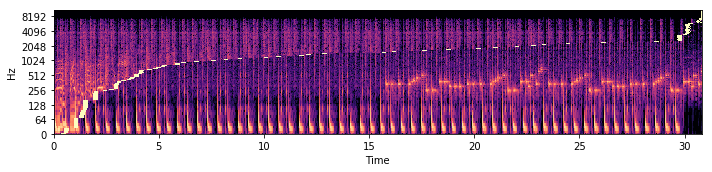

In [29]:
r, rr = lr.core.load(output_name, sr=None)
r_fourier = lr.stft(r, n_fft=2048)
r_cut_fourier = lr.amplitude_to_db(r_fourier[:,fourier_transformed1.shape[1]-overlap:fourier_transformed1.shape[1]],ref=np.max)

for row in range(cut.shape[0]):
    first_right = 10
    for x in range(cut.shape[1]):
        if cut[row,x]:
            if first_right:
                r_cut_fourier[row,x] = 0
                r_cut_fourier[row,x-((10-first_right)*2)] = 0
                first_right -=1

plt.figure(figsize=(10,2.5))
display.specshow(r_cut_fourier,
                         y_axis='log', 
                         x_axis='time',
                         hop_length=2048/8)
#plt.colorbar(format='%+2.0f dB')
#plt.title('Graph Cut Spectrogram')
plt.tight_layout()
#plt.show()
plt.savefig('test.pdf')

c:\program files\python36\lib\site-packages\librosa\core\spectrum.py:1029: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


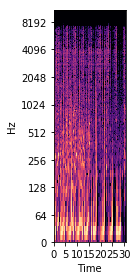

In [49]:
temp = lr.amplitude_to_db(fourier_transformed1,ref=np.max)
#temp = temp[:,:overlap]
temp = temp[:,temp.shape[1]-overlap:]
#temp[:,temp.shape[1]-overlap-30:temp.shape[1]-overlap+30] = 0
#temp[:,overlap-30:overlap+30] = 0
#temp = r_cut_fourier.copy()
#temp[:,fourier_transformed1.shape[1]-overlap-35:fourier_transformed1.shape[1]-overlap+35] = 0
#temp[:,fourier_transformed1.shape[1]-35:fourier_transformed1.shape[1]+35] = 0
plt.figure(figsize=(2,4))
display.specshow(temp,y_axis='log', x_axis='time', hop_length=2048/8)
#plt.colorbar(format='%+2.0f dB')
#plt.title('Graph Cut Spectrogram')
plt.tight_layout()
#plt.show()
plt.savefig('for_fig1.pdf')

In [45]:
s1dB

array([[-50.975163, -53.294724, -80.      , ..., -67.111694, -58.73698 ,
        -61.41937 ],
       [-57.611187, -54.25634 , -51.839043, ..., -65.56312 , -61.12285 ,
        -61.914726],
       [-59.023148, -49.176353, -48.101814, ..., -63.212013, -62.555405,
        -64.08726 ],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

# Applying EQ filters to repeat the sound (This was abandoned)

In [ ]:
part_1 = np.copy(y)
part_2 = np.copy(y)

freq_conversion = round((sr/2)/fourier_transformed.shape[0])
time_conversion = round(part_1.shape[0]/fourier_transformed.shape[1])
bands = np.geomspace(30,sr/2, num=20).astype(int)[:-1]
rows = list(map(lambda x: int(round(x/freq_conversion))-1, bands))
gain = -25
q = 2.5


def get_EQ_indices(rows, cut, sound, tc):
    cut_column = []
    for i in range(len(rows)):
        
        if i == 0:
            upper_bound = int(round(np.mean((rows[i],rows[i+1]))))
            lower_bound = 0
            
        elif i == len(rows)-1:
            upper_bound = cut.shape[0]
            lower_bound = int(round(np.mean((rows[i],rows[i-1]))))
        else:
            upper_bound = int(round(np.mean((rows[i],rows[i+1]))))
            lower_bound = int(round(np.mean((rows[i],rows[i-1]))))
        
        #print('\n')
        #print(i)
        #print(rows[i])
        #print(len(rows))
        #print(lower_bound, upper_bound)
        bool_vector = sp.stats.mode(cut[lower_bound:upper_bound,:], axis=0)[0][0]
        cut_column.append(np.argmax(bool_vector))
        
    s1_indices = np.array(list(map(lambda x: int(round((sound.shape[1]-cut.shape[1]+x)*tc)), cut_column)))
    s2_indices = np.around(np.array(cut_column)*tc).astype(int)
    
    return s1_indices, s2_indices

s1_i, s2_i = get_EQ_indices(rows, cut, fourier_transformed, time_conversion)
            
for freq, i, j in zip(bands, s1_i, s2_i):
    
    fx1 = audaugio.chain.LinearChain(
        audaugio.augmentation.EqualizerAugmentation(freq,q,gain)
    )
    fx2 = audaugio.chain.LinearChain(
        audaugio.augmentation.EqualizerAugmentation(freq,q,gain)
    )

    part_1[i:] = fx1(part_1[i:],sr)[0]
    part_2[:j] = fx2(part_2[:j],sr)[0]
    
augmented_audio = (part_1[-round(overlap*time_conversion):]+part_2[:round(overlap*time_conversion)])/2

audio_out = np.concatenate((part_1[:-round(overlap*time_conversion)],augmented_audio,part_2[round(overlap*time_conversion):]))

S = np.abs(lr.stft(augmented_audio))

plt.figure(figsize=(10,4))
display.specshow(lr.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Power spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
lr.output.write_wav('augmented_'+str(file)+'_eq', audio_out, sr=sr)

In [ ]:
lr.output.write_wav('augmented_control_'+str(file1), np.concatenate((y1,y2,y1),axis=None), sr=sr)

In [51]:
l = []*5
l[0]

IndexError: list index out of range